# Open MERRA-2 netCDF files from S3 storage as zarr stores using a pre-made sidecar metadata file

## This notebook serves you:
1) Shared directory location of a sidecar metadata file (.json)
2) Code for using the metadata file to read MERRA-2 netCDFs from S3 storage like zarr stores

### Import modules

In [9]:
import requests
import xarray as xr
import s3fs
import fsspec
import hvplot.xarray

# The xarray produced from the reference file throws a SerializationWarning for each variable. Will need to explore why
import warnings
warnings.simplefilter("ignore")

### Get authentication and set up file system

In [3]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

response = requests.get(gesdisc_s3).json()
fs = s3fs.S3FileSystem(key=response['accessKeyId'],
                    secret=response['secretAccessKey'],
                    token=response['sessionToken'],
                    client_kwargs={'region_name':'us-west-2'})

### Define parameters for fsspec that include us-west-2 credentials

In [4]:
s_opts = {'skip_instance_cache':True}
r_opts = {'anon':False,
          'key':response['accessKeyId'],
          'secret':response['secretAccessKey'],
          'token':response['sessionToken']}

### Path to combined json file containing metadata for one month (March 2019) of hourly MERRA-2 files

In [6]:
metadata_json_path = "~/shared/mapes/combined.json"

### Use fsspec to call upon the metadata file to extract metadata about S3 location and file structure and open as an xarray Dataset

The combined metadata file was pre-generated using the kerchunk library. It contains metadata for hourly MERRA-2 SLV files from March 2019 (31 days)

In [10]:
%%time

fs = fsspec.filesystem(
    "reference", 
    fo=metadata_json_path,
    remote_protocol="s3", 
    remote_options=r_opts,
    ref_storage_args=s_opts
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine='zarr') #don't use xr.open_mfdataset
ds

CPU times: user 639 ms, sys: 24.4 ms, total: 663 ms
Wall time: 730 ms


<xarray.Dataset>
Dimensions:   (time: 744, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[us] 2019-03-01T00:30:00 ... 2019-03-31T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 ...
    CLDTMP    (time, lat, lon) float32 ...
    DISPH     (time, lat, lon) float32 ...
    H1000     (time, lat, lon) float32 ...
    H250      (time, lat, lon) float32 ...
    H500      (time, lat, lon) float32 ...
    ...        ...
    V250      (time, lat, lon) float32 ...
    V2M       (time, lat, lon) float32 ...
    V500      (time, lat, lon) float32 ...
    V50M      (time, lat, lon) float32 ...
    V850      (time, lat, lon) float32 ...
    ZLCL      (time, lat, lon) float32 ...
Attributes: (12/30)
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    EasternmostLongitude:              179.375
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20190301.nc4
    ...                                ...
    TemporalRange:                     1980-01-01 -> 2016-12-31
    Title:                             MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    identifier_product_doi_authority:  http://dx.doi.org/

### Plot temperature for the first time in the array

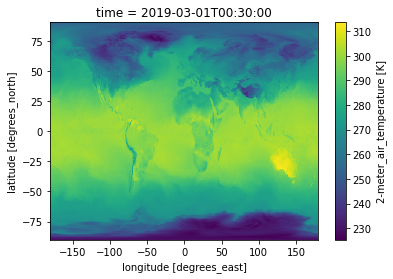

In [12]:
ds.T2M[0,:,:].plot()